In [151]:
import pandas as pd
import numpy as np
import itertools
import scipy.stats as st
from sklearn.metrics import r2_score
import seaborn as sns; sns.set_theme(color_codes=False)
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
def get_all_params(df):
    """Initializes the variables containing the run names and the parameters dictionary for each run."""
    
    def get_run_params(run):
        result = {}
        params = df[df.type == "param"]
        for index, row in params[params.run == run].iterrows():
            # Convert numerical values to float
            try:
                result[row.attrname] = float(row.attrvalue)
            except ValueError:
                result[row.attrname] = row.attrvalue
        return result
    
    global all_params, all_runs
    
    all_params = {}
    all_runs = df.run.unique()
    for run in all_runs:       
        all_params[run] = get_run_params(run)

In [9]:
def find_runs(params={}):
    """Returns an array containing the run names with the parameters provided as a dictionary."""
    
    if params == {}:
        return all_runs.tolist()
    
    result = []
    
    for run in all_runs:       
        run_params = all_params[run]
        to_keep = True
                
        for name, value in params.items():
            if type(value) is str:
                check_value = '"'+value+'"'
            else:
                check_value = value
                
            if name not in run_params or run_params[name] != check_value:
                to_keep = False
                break
        if to_keep:      
            result.append(run)
                
    return result

In [185]:
def get_vecvalue(run, name):
    """Returns an array containing the values of a given vector for the specified run."""
     
    try:
    return np.fromstring(df[(df.type == "vector") & (df.run == run) & (df.name == name)].iloc[0].vecvalue, 
                             sep=" ", dtype=np.double)
    except Exception:
        return np.array([])


def get_vectime(run, name):
    """Returns an array containing the time values of a given vector for the specified run."""
    
    try:
        return np.fromstring(df[(df.type == "vector") & (df.run == run) & (df.name == name)].iloc[0].vectime, 
                             sep=" ", dtype=np.double)
    except Exception:
        return np.array([])

    
def get_scalar(run, name):
    """Returns the scalar value of the given statistic for the specified run."""
    strvalue = df[(df.type == "scalar") & (df.run == run) & (df.name == name)].iloc[0].value
    try:
        return float(value)
    except Exception:
        return strvalue

IndentationError: expected an indented block (Temp/ipykernel_18464/1676890957.py, line 5)

In [11]:
def get_throughput(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'Throughput:vector')


def get_throughput_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'Throughput:vector')


def get_rt(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'ResponseTime:vector')


def get_rt_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'ResponseTime:vector')


def get_num_plane(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'numPlane:vector')


def get_num_plane_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'numPlane:vector')


def get_landing_queue(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'LandingQueueTime:vector')


def get_landing_queue_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'LandingQueueTime:vector')


def get_takeoff_queue(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'TakeoffQueueTime:vector')


def get_takeoff_queue_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'TakeoffQueueTime:vector')


def get_LQ_len(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'LQ_length:vector')


def get_LQ_len_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'LQ_length:vector')


def get_TQ_len(run):
    
    if run is None:
        return None
                          
    return get_vecvalue(run, 'TQ_length:vector')


def get_TQ_len_time(run):
    
    if run is None:
        return None
                          
    return get_vectime(run, 'TQ_length:vector')


def get_ROT(run):
    
    if run is None:
        return None

    return get_scalar(run, 'ROT')

In [12]:
def get_param_values(param_name):
    """Returns all values for a given parameter in the set of runs."""
    
    param_values = set()
    for key in all_params.keys():
        param_values.add(all_params[key][param_name])
    
    return param_values


def get_combinations(*params):
    """Returns a list of all the possible combinations of parameter values, for the specified parameters."""
    
    param_values = [] 
    for param in params:
        param_values.append(get_param_values(param))
        
    result = []
    combinations = itertools.product(*param_values)
    for item in combinations:
        combination = {}
        for idx, param in enumerate(params):
            combination[param] = item[idx]
        result.append(combination)
    
    return result

In [13]:
def plot_calibration(combinations):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for combination in combinations:
        runs = find_runs(combination)
        mean_rts = []
        mean_rt_iats = []
        for run in sorted(runs, key=lambda x: (all_params[x]['**.interarrivalTimeAvg'])):
            mean_rts.append(np.mean(get_rt(run)))
            mean_rt_iats.append(all_params[run]['**.interarrivalTimeAvg'])
        x = np.array(mean_rt_iats, dtype=int)
        y = np.array(mean_rts, dtype=float)
        ax.plot(x, y, label=str(combination))
    
    plt.legend()
    plt.xlabel("Mean interarrival time (s)")
    plt.ylabel("Mean response time (s)")
    plt.grid(True, 'both')
    plt.savefig('../results/plots/queue_study.pdf', bbox_inches='tight')

In [42]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_rot.csv')
get_all_params(df)

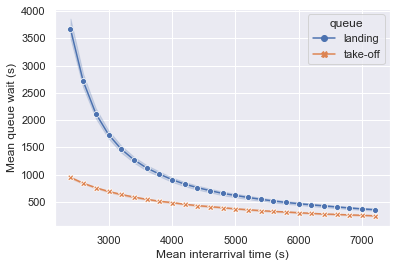

In [138]:
iats = range(2400, 7300, 200)
rows = []

for iat in iats:
    runs = find_runs({'**.interarrivalTimeAvg': float(iat)})
    for rep, run in enumerate(runs):
        rot = get_ROT(run)
        tq_wait = np.mean(get_takeoff_queue(run))
        lq_wait = np.mean(get_landing_queue(run))
        row = {'iat': iat, 'rep': rep, 'wait': lq_wait, 'queue': 'landing'}
        rows.append(row)
        row = {'iat': iat, 'rep': rep, 'wait': tq_wait, 'queue': 'take-off'}
        rows.append(row)

data = pd.DataFrame(rows)
fig = sns.lineplot(data=data, x='iat', y='wait', hue='queue', style='queue', markers=True, dashes=False)
plt.xlabel("Mean interarrival time (s)")
plt.ylabel("Mean queue wait (s)")
plt.grid(True, 'both')
plt.show()

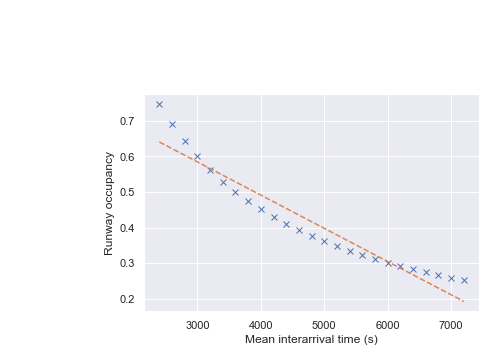

In [139]:
rots = []

for iat in iats:
    runs = find_runs({'**.interarrivalTimeAvg': float(iat)})
    temp = []
    for run in runs:
        rot = get_ROT(run)
        temp.append(rot)
    rots.append(np.mean(temp))

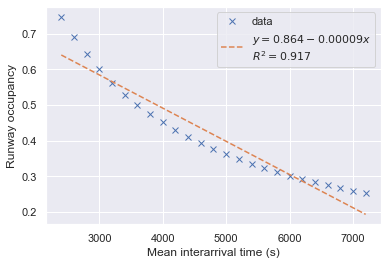

In [155]:
_, ax = plt.subplots(1)
m, b = np.polyfit(iats, rots, 1)
rots_predicted = [m * x + b for x in iats]
r_squared = r2_score(rots, rots_predicted)
ax.plot(iats, rots, 'x', label="data")
ax.plot(iats, m * iats + b, '--', label="$y = {:.3f}{:.5f}x $\n$R^2 = {:.3f}$".format(b, m, r_squared))
plt.legend()
plt.xlabel("Mean interarrival time (s)")
plt.ylabel("Runway occupancy")
plt.grid(True, 'both')
plt.show()

In [186]:
all_params = {}
all_runs = None
df = pd.read_csv('../results/control_tower_queues.csv')
get_all_params(df)

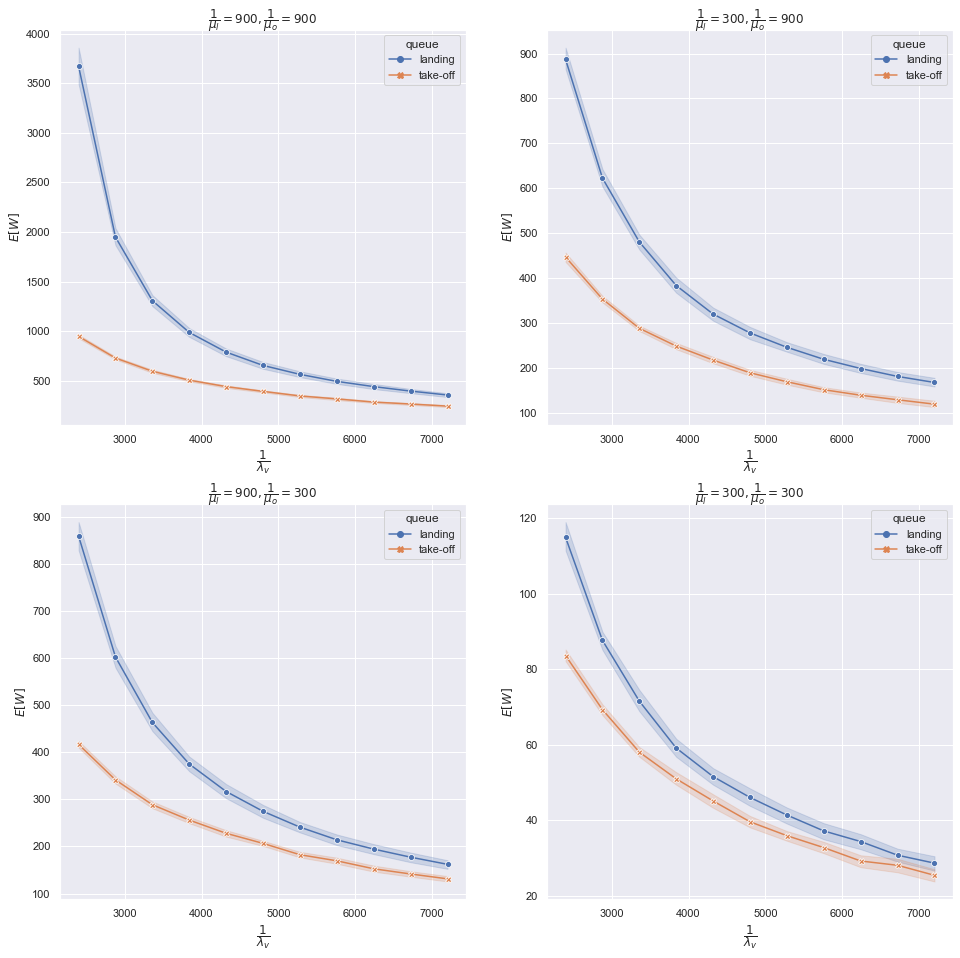

In [188]:

combinations = get_combinations('**.landingTimeAvg', '**.takeoffTimeAvg')

fig, axs = plt.subplots(2, 2)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, combination in enumerate(combinations):
    p = axs[i%2, i//2]
    p.set_title(f"$\dfrac{{1}}{{\mu_l}}={int(combination['**.landingTimeAvg'])}, \dfrac{{1}}{{\mu_o}}={int(combination['**.takeoffTimeAvg'])}$")
    p.set_xlabel("$\dfrac{{1}}{{\lambda_v}}$")
    p.set_ylabel("$E[W]$")
    
    rows = []
    for iat in range(2400, 7201, 480):
        combination['**.interarrivalTimeAvg'] = float(iat)
        runs = find_runs(combination)
          
        for rep, run in enumerate(runs):
            tq_wait = np.mean(get_takeoff_queue(run))
            lq_wait = np.mean(get_landing_queue(run))
            row = {'iat': float(iat), 'rep': rep, 'wait': lq_wait, 'queue': 'landing'}
            rows.append(row)
            row = {'iat': float(iat), 'rep': rep, 'wait': tq_wait, 'queue': 'take-off'}
            rows.append(row)

    data = pd.DataFrame(rows)
    sns.lineplot(data=data, x='iat', y='wait', hue='queue', style='queue', markers=True, dashes=False, ax=p)
    p.grid(True, 'both')
plt.show()



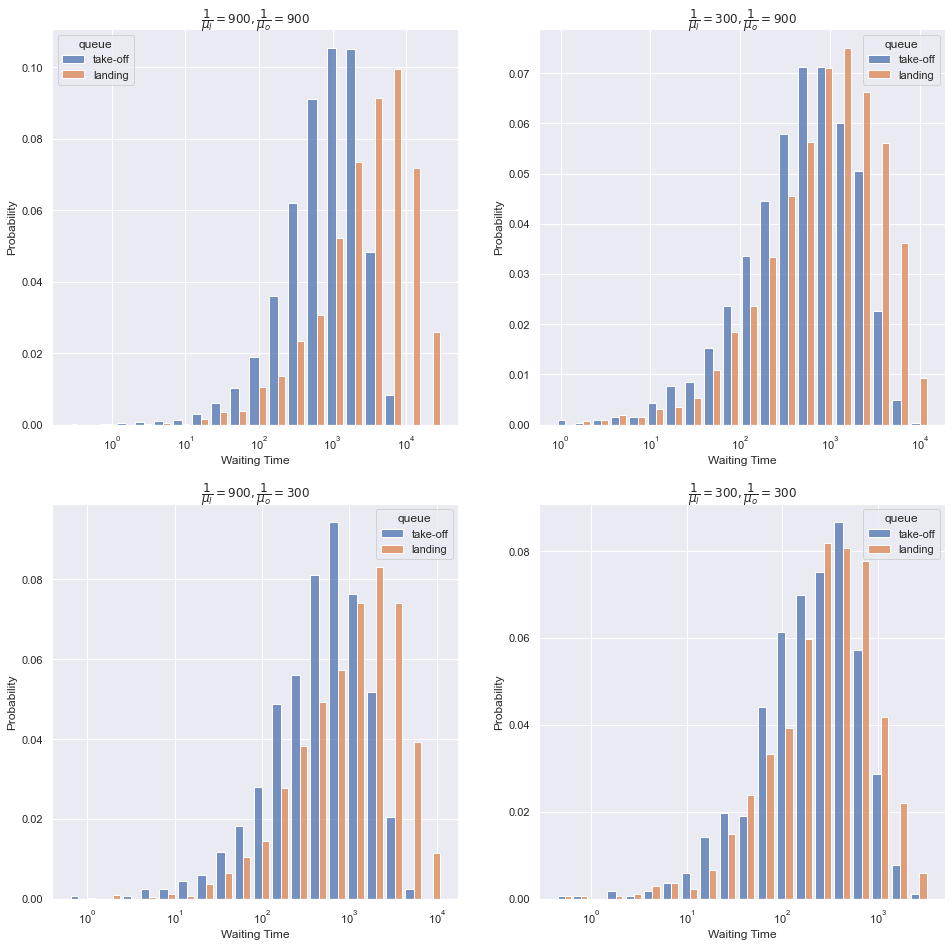

In [202]:
combinations = get_combinations('**.landingTimeAvg', '**.takeoffTimeAvg')

fig, axs = plt.subplots(2, 2)
fig.set_figheight(16)
fig.set_figwidth(16)

for i, combination in enumerate(combinations):
    p = axs[i%2, i//2]
    p.set_title(f"$\dfrac{{1}}{{\mu_l}}={int(combination['**.landingTimeAvg'])}, \dfrac{{1}}{{\mu_o}}={int(combination['**.takeoffTimeAvg'])}$")
    p.set_xlabel("Waiting Time")
    p.set_ylabel("Probability")
    
    rows = []
    
    combination['**.interarrivalTimeAvg'] = 2400.0
    runs = find_runs(combination)
    
    tq_waits = get_takeoff_queue(runs[0])
    for tq_wait in tq_waits:
        if not tq_wait:
            continue
        row = {'wait': tq_wait, 'queue': 'take-off'}
        rows.append(row)
    
    lq_waits = get_landing_queue(runs[0])
    for lq_wait in lq_waits:
        if not lq_wait:
            continue
        row = {'wait': lq_wait, 'queue': 'landing'}
        rows.append(row)
        
    data = pd.DataFrame(rows)
    sns.histplot(data=data, x="wait", hue="queue", multiple="dodge", stat="probability", shrink=.8, log_scale=True, bins=20, ax=p)
plt.show()